# Episode 05: Proofs of concepts

In Episode 03, some potential problem solving strategies or heuristics. Fitted out with the  classes improved in Episode 04, let's try to solve the problem.

In this Episode will be focuse on exploring different technologies and check whether it is useful for solving this problem.

We willmost of time focus on 2x2 simple problems and assume that we know a solution to the problem. The latter will simplify the problem by allowing to check if the proposed solution aquals the expected solution instead of verifying if the solution works.

**Goals for this episode:**
- Try to solve the puzzle with the board defined in Episode 04
- List potential strategies or heuristics
- solve simple 2x2 problem with a known solution

In [ ]:
# TODO group by categories 
?
optimizers
machine learning - NLP /transformers


use only known solutions and 2x2 here

# 1. Some initialisations

In [162]:
from episode04 import clues2x2, solution2x2, clues5x5s, solution5x5s
from episode04 import Puzzle, Board, BoardMark, GameEngine

import numpy as np

In [166]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

In [167]:
solution2x2

array([[1, 0],
       [1, 1]])

# 2. Try-and-error process

Having an idea from scratch is difficult.

The contract with the platyer for Nonograms is that they always have 1 solution. Let's say we know that there is a solution. We can try different values for each cell until the board is solved.

Even if this process is probably not what we want, it will help undestand what we need to solve the puzzle. 

In addition, it make sense in AI. Some algorithms, especially in Reinforcement Learning, work by learning from try-and-error process. They are given the goal to keep errors to a minimulm.

What could be the try-and-error process ?

For each cell, I know that it could be black or filler. 

We need some game engine to decide whether the action is valid or not according to be solution it knows already. 

Now, let's loop over the problem space

## 2.2. Experiments

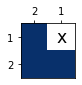

error_count:1


In [168]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

for row in range(board2x2.height):
    for col in range(board2x2.width):
        if game2x2.is_action_valid(row, col, BoardMark.BLACK):
            board2x2.mark(row, col, BoardMark.BLACK)
        else: 
            board2x2.mark(row, col, BoardMark.FILLER)

game2x2.show_board()
print(f"error_count:{game2x2.errors}")

Voila!

I agree that this algorithm is pretty dump. The percentage of errors goes up very rapidly and exceed what the game will accept (usually 3 errors). On the 5x5 board it took 11 errors to solve 25 cells.

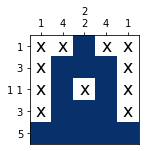

error_count:11


In [169]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

for row in range(board5x5s.height):
    for col in range(board5x5s.width):
        if game5x5s.is_action_valid(row, col, BoardMark.BLACK):
            board5x5s.mark(row, col, BoardMark.BLACK)
        else: 
            board5x5s.mark(row, col, BoardMark.FILLER)

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")

# 2.3  Wrap up

What works:
- it is really simple to design and implement
- no computation, no headache with split blocks

Limitation:
- requires that the solution is known beforehand
- roughly 50% error rate. It depends on the proportion of blacks and fillers,  and whether blacks or fillers are checked for validity

# 3. Brute Force

The idea behind brute force is to generate all possible options and then check which one is vaid.

Unlike try-and-error the validation will take place on the whole board. We do not need to know the solution beforehand. The engine can compute the clues from the board and check whether the board holds or breaks the clues.

## 3.1. Experiment on 2x2

The first step is listing all possible options for the oard.

The board is a list of 0 and 1. From the clues we know the number of black cells. It is the sum of all clues.

All possible boards are permutations of this black cells over the cells of the board. If I have [1,0] all permutations are [1,0] and [0,1]

In [170]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [173]:
# create two generators, one for black cells and the other for fillers
from itertools import repeat, chain, tee
# 3 blacks
black_iterator = repeat(BoardMark.BLACK.value, puzzle2x2.required_blacks_count) 
# 1 filler
fillers_count = puzzle2x2.cells_count - puzzle2x2.required_blacks_count
filler_iterator = repeat(BoardMark.FILLER.value, fillers_count) 
# chain concatenate both iterators
# tee is used for debugging, it duplicates the iterator which otherwize could be consummed only once
initial_states_iterator, debug_iterator = tee(chain(black_iterator, filler_iterator))
# show the value for debugging
list(debug_iterator)

[1, 1, 1, 0]

In [174]:
# generate permutations 
from itertools import permutations
permutations_iterator, debug_iterator = tee(permutations(initial_states_iterator))
list(debug_iterator)
# there are 16 because permutation switch elements of the list and not values
# it does not take care that 1 occurs many times

[(1, 1, 1, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 0, 1, 1), (1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 0, 1, 1), (1, 0, 1, 1), (0, 1, 1, 1), (0, 1, 1, 1), (0, 1, 1, 1), (0, 1, 1, 1), (0, 1, 1, 1), (0, 1, 1, 1)]

In [179]:
# browse all boards and select valid ones
import numpy as np

# set avoids duplicates generated by permutations
for o in set(permutations_iterator):
    print(f"option:{o}")
    # select valid options - o is a tuple not a list
    if game2x2.is_expected_solution(list(o)):
        print(f"valid:{o}")
        board2x2.fill_all(o)

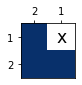

In [180]:
game2x2.show_board()

## 3.2. Experiment on 2x2 - Alternative implementation

Another way of analysing this problem is to compute all possible indexes of black cells instead of all possible boards.

Let's take an example. Say there is a jar with numbers from 0 to 3. These are possible positions of a cell in the board. I want to draw 3 numbers from the jar. This is named a combination of 3 out of 4.

In [181]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [182]:
# draw the position numbers from the pool of indexes
from itertools import combinations, tee
# want to get 3 positions in a range 0 - 4 where 4 is the number of cells
# we want each position to be unique thus no replacement
values = range(puzzle2x2.cells_count)
nb_drawn = puzzle2x2.required_blacks_count
temp_combinations_iterator = combinations(values, nb_drawn) 
combinations_iterator, debug_iterator = tee(temp_combinations_iterator)
list(debug_iterator)

[(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

In [183]:
# browse the options, buold the board and select valid boards
import numpy as np

for option in combinations_iterator:
    print(f"option:{option}")
    # compute the board state
    # put black at each position in combinations_iterator and fillers elsewhere
    states = np.full(puzzle2x2.cells_count, BoardMark.FILLER.value, dtype=int)
    # put black at each position in combinations_iterator and fillers elsewhere
    for pos in option:
        states.flat[pos] = BoardMark.BLACK.value
    
    # select valid options
    if game2x2.is_expected_solution(states.tolist()): 
        print(f"valid:{states}")
        # batch update the board flattent to 1D
        board2x2.fill_all(states)

option:(0, 1, 2)
option:(0, 1, 3)
option:(0, 2, 3)
valid:[1 0 1 1]
option:(1, 2, 3)


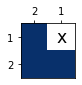

In [184]:
game2x2.show_board()

## 3.3. Wrap up

What works:
- it is simple to design and implement
- no computation, no headache with split blocks

Limitation:
- number of options  increase rapidly with the size of the board. 

In addition all these options will have to be checked for validity. We used known solutions here  because they are available but in a real use case we would evaluate whether the option match the clues for each option.

The number of options increases lower with implementation 2 because the problem space is smaller. It is the number of blacks instead of the number of cells (blacks are usually around 50% of cells). However it increases rapidly.

In [185]:
from itertools import combinations

In [186]:
%time
from itertools import combinations
black_count = 4
cells_count = 9
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


126

In [187]:
%time
black_count = 7
cells_count = 16
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


11440

In [188]:
%time
black_count = 14
cells_count = 25
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


4457400

# 4. Programming with constraints

Wikipedia defines constraint Programming as following: 

>    Constraint programming is a paradigm for solving combinatorial problems that draws on a wide range of techniques from artificial intelligence, computer science, and operations research. In constraint programming, users declaratively state the constraints on the feasible solutions for a set of decision variables. Constraints differ from the common primitives of imperative programming languages in that they do not specify a step or sequence of steps to execute, but rather the properties of a solution to be found. In addition to constraints, users also need to specify a method to solve these constraints. This typically draws upon standard methods like chronological backtracking and constraint propagation, but may use customized code like a problem specific branching heuristic. 

Python-contraint offers solvers for Constraint Satisfaction Problems (CSPs) over finite domains in simple and pure Python. CSP is class of problems which may be represented in terms of variables (a, b, …), domains (a in [1, 2, 3], …), and constraints (a < b, …).

https://pypi.org/project/python-constraint/


Alternative (TODO)

In [ ]:
! pip install python-constraint

In [193]:
from constraint import Problem

## 4.1. Basic example from the tutorial

This example shows how to define a and b, a being in the range 1,2,3 and b in the range 4,5,6 so b is 2 time a.

In [194]:
problem = Problem()
problem.addVariable("a", [1,2,3])
problem.addVariable("b", [4,5,6])
problem.getSolutions()

[{'a': 3, 'b': 6}, {'a': 3, 'b': 5}, {'a': 3, 'b': 4}, {'a': 2, 'b': 6}, {'a': 2, 'b': 5}, {'a': 2, 'b': 4}, {'a': 1, 'b': 6}, {'a': 1, 'b': 5}, {'a': 1, 'b': 4}]

Without constraints it does a cartesian product of variables a and b. The result is all possible combinations of a and b.

The constraint force to filter only pairs where b is twice a. It can be implemented as a lambda function.

In [195]:
problem.addConstraint(lambda a, b: a*2 == b,
                          ("a", "b"))
problem.getSolutions()

[{'a': 3, 'b': 6}, {'a': 2, 'b': 4}]

## 4.2. Application to the monogram problem

In [196]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [197]:
# solve the problem for a 2x2 board
problem = Problem()

# create a variable for each cell
# name is rNcM where N is the row number and M the col number
# they all are in range 0-1
problem.addVariable("r0c0", [0,1])
problem.addVariable("r0c1", [0,1])
problem.addVariable("r1c0", [0,1])
problem.addVariable("r1c1", [0,1])
problem.getSolutions()

[{'r0c0': 1, 'r0c1': 1, 'r1c0': 1, 'r1c1': 1}, {'r0c0': 1, 'r0c1': 1, 'r1c0': 1, 'r1c1': 0}, {'r0c0': 1, 'r0c1': 1, 'r1c0': 0, 'r1c1': 1}, {'r0c0': 1, 'r0c1': 1, 'r1c0': 0, 'r1c1': 0}, {'r0c0': 1, 'r0c1': 0, 'r1c0': 1, 'r1c1': 1}, {'r0c0': 1, 'r0c1': 0, 'r1c0': 1, 'r1c1': 0}, {'r0c0': 1, 'r0c1': 0, 'r1c0': 0, 'r1c1': 1}, {'r0c0': 1, 'r0c1': 0, 'r1c0': 0, 'r1c1': 0}, {'r0c0': 0, 'r0c1': 1, 'r1c0': 1, 'r1c1': 1}, {'r0c0': 0, 'r0c1': 1, 'r1c0': 1, 'r1c1': 0}, {'r0c0': 0, 'r0c1': 1, 'r1c0': 0, 'r1c1': 1}, {'r0c0': 0, 'r0c1': 1, 'r1c0': 0, 'r1c1': 0}, {'r0c0': 0, 'r0c1': 0, 'r1c0': 1, 'r1c1': 1}, {'r0c0': 0, 'r0c1': 0, 'r1c0': 1, 'r1c1': 0}, {'r0c0': 0, 'r0c1': 0, 'r1c0': 0, 'r1c1': 1}, {'r0c0': 0, 'r0c1': 0, 'r1c0': 0, 'r1c1': 0}]

In [198]:
# express the clues as contraints in a static way
# last parameter is the given variables. They match the lambda vars.
# contraints on rows
problem.addConstraint(lambda c0, c1: c0+c1 == 1,
                          ("r0c0", "r0c1"))
problem.addConstraint(lambda c0, c1: c0+c1 == 2,
                          ("r1c0", "r1c1"))
# contraints on cols
problem.addConstraint(lambda r0, r1: r0+r1 == 2,
                          ("r0c0", "r1c0"))
problem.addConstraint(lambda r0, r1: r0+r1 == 1,
                          ("r0c1", "r1c1"))
solutions = problem.getSolutions()
solutions

[{'r0c0': 1, 'r0c1': 0, 'r1c0': 1, 'r1c1': 1}]

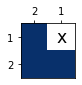

True

In [199]:
# update the board with solution
board2x2.mark(0,0, BoardMark(solutions[0]['r0c0']))
board2x2.mark(0,1, BoardMark(solutions[0]['r0c1']))
board2x2.mark(1,0, BoardMark(solutions[0]['r1c0']))
board2x2.mark(1,1, BoardMark(solutions[0]['r1c1']))

game2x2.show_board()
game2x2.is_solved()

## 4.3. Wrap up

What works:
- problem is expressed clearly
- documentation in clean and a totorial is provided. It took me a while to understand what is going on with variables and it is still unclear to me how to use built-in function

Limitation:
- As it seems to compute all the combinations, it may run into the same limitations than brute foree. To be tested
- Generalisation to any size and split blocks is more challenging. It does not hava a notion of an array. Each variable must be handled separatelly.  Interesting challenge!

Challenges for further prototyping
- generate variable names and contraints
- write contraints for variable size
- write contraints for split blocks

- Ideation: 30mn - classical paradigm 
- Design: 1h - feature out how to manage variables for board - lib was new to me
- Implementation: 2h - generic representation of rules - for whole POC - 5-6h

# 5. Dynamic programming

Wikipedia defines constraint Programming as following: 
> Dynamic programming is both a mathematical optimization method and a computer programming method. The method was developed by Richard Bellman in the 1950s and has found applications in numerous fields, from aerospace engineering to economics.
>In both contexts it refers to simplifying a complicated problem by breaking it down into simpler sub-problems in a recursive manner. 

Implement often rely on recursion and reduce or fold method.
> In functional programming, fold (also termed reduce, accumulate, aggregate, compress, or inject) refers to a family of higher-order functions that analyze a recursive data structure and through use of a given combining operation, recombine the results of recursively processing its constituent parts, building up a return value. Typically, a fold is presented with a combining function, a top node of a data structure, and possibly some default values to be used under certain conditions. The fold then proceeds to combine elements of the data structure's hierarchy, using the function in a systematic way.  - Wikipedia

## 5.1. Simple exemple with a sum

Say we want to do the sum of 4 numbers [2, 4, 3, 1].

What is the subproblem ? 

Do the element of the list to the sum of the elements of the rest of the list. 

This process can be repeated for 3 and 2 numbers. It stops when there is no number in the list anymore.

This proxess is called folding or reduce. 
- Each step the problem is reduced, has less numbers. 
- The recursion create a tree of subproblem that will be unfolded and folded

In [209]:
# sum numbers
def fold(numbers, total):
    print(f"numbers:{numbers} - total:{total}")
    if len(numbers) == 0:
        return total
    return fold(numbers[1:], total+numbers[0])
    
total = fold([2, 4, 3, 1], 0)
total

numbers:[2, 4, 3, 1] - total:0
numbers:[4, 3, 1] - total:2
numbers:[3, 1] - total:6
numbers:[1] - total:9
numbers:[] - total:10


10

## 5.2. Application to he 2x2 board

I suggled a lot to define what is the problem and the subproblem. Is it the clues lists ? Is it the board states ?

What are the subproblems here ?

Let's say that the subproblem is 
```
10
1?
```
I must replace the ? by 0 or 1
- 0 would break the clues for row 1 (2 expected)
- 1 would hold the clue and solve the board

To go there I solved a simplier subproblem
```
10
?
```
I must replace the ? by 0 or 1
- 0 would break the clues because col 0 expects 2
- 1 would hold the clue for this subproblem

By filling the bard cell by cell, all the hypothesis could be explored and selected when they do not breal the clues.

Let's start by building a list of all possible boards.

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [238]:
# all boards
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells):
    #print(f"cells:{cells}")
    if len(cells) == board_lenght:
        # found a board - will add to the list of boards
        return [cells]
    
    # boards built in this subproblem
    boards = []
    boards.extend(fold(cells + [0])) 
    boards.extend(fold(cells + [1])) 
    return boards

fold([])

[[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]

In [235]:
# all boards matching the solution
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells):
    #print(f"cells:{cells}")
    if len(cells) == board_lenght:
        if game2x2.is_expected_solution(cells):
            # found a board - will add to the list of boards
            return [cells]
        else:
            # drop - stop the folding bit does not add to the listt
            #print(f"drop {cells}")
            return []
   
    # boards built in this subproblem
    boards = []
    boards.extend(fold(cells + [0])) 
    boards.extend(fold(cells + [1])) 
    return boards

fold([])

[[1, 0, 1, 1]]

A better solution would to stop fold as long as a clue is broken

In [237]:
# all boards matching the solution
from math import floor
import copy
board_lenght = 4 # 2x2
def fold(cells, pos, running_sum):
    if len(cells) == board_lenght:
        if running_sum['rows'] == clues2x2['rows'] and running_sum['cols'] == clues2x2['cols']:
            # found a board - will add to the list of boards
            return [cells]
        else:
            # drop - stop the folding but does not add to the listt
            #print(f"drop {cells}")
            return []

    row = floor(pos/2)
    col = pos%2
    #print(f"cells:{cells} - pos:{pos} - row:{row} - col:{col} - running_sum:{running_sum}")
    
    if running_sum['rows'][row] > clues2x2['rows'][row]:
        #print(f"drop {cells}")
        return [] # drop - clue is broken
    
    if running_sum['cols'][col] > clues2x2['cols'][col]:
        #print(f"drop {cells}")
        return [] # drop - clue is broken 

    # boards built in this subproblem
    boards = []
    # 0 do not alter the sum
    boards.extend(fold(cells + [0], pos+1, running_sum))
    # 1 will be added to the running_sum
    # need a different dict otherwize reference is modified
    new_running_sum = copy.deepcopy(running_sum)
    new_running_sum['rows'][row] += 1
    new_running_sum['cols'][col] += 1
    boards.extend(fold(cells + [1], pos+1, new_running_sum))
    return boards

fold([], 0, {'rows':[0,0], 'cols':[0,0]}, )

[[1, 0, 1, 1]]

## 5.3. Wrap up

What works:
- a classical implementation

Limitation:
- Code is a bit tricky

The main idea is implemented. Need some improvement to running sum with split block and tests against the 5x5s game


- Ideation: 30mn - classical paradigm 
- Design: 4h - for whatever reason I could not feature out what the problem is and that I don,ot need to validate the rule on subproblem, only prune folds where the rule are broken (when sum is over the clue). My first go was that the subproblem were each element of the clue
- Implementation: 3h - a bit tricly to solve the list of list, then the running sum

# 6. Probabilistic approach

TODO

In [3]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

row 0 could be [x, o] or [o, x] 
=> probability of black is 0.5
col 0 could be [x, o] or [o, x] 
=> probability of black is 0.5
probability of top left cell to be black of probability of being black for row and black for col is the multiplication of probabilities

In [7]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [8]:
probs2x2 = np.full((board2x2.height, board2x2.width), -1, dtype=float)
for i_row in range(len(clues2x2['rows'])):
    sum_row = clues2x2['rows'][i_row]
    for i_col in range(len(clues2x2['cols'])):
        sum_col = clues2x2['cols'][i_col]
        probs2x2[i_row, i_col] = (sum_row/board2x2.width) * (sum_col/board2x2.height)
        
probs2x2

array([[0.5 , 0.25],
       [1.  , 0.5 ]])

In [ ]:
it is actually wrong from here. 0.5 is undecided

In [244]:
probs2x2 = np.full((board2x2.height, board2x2.width), -1, dtype=float)
for i_row in range(len(clues2x2['rows'])):
    sum_row = clues2x2['rows'][i_row]
    for i_col in range(len(clues2x2['cols'])):
        sum_col = clues2x2['cols'][i_col]
        probs2x2[i_row, i_col] = max((sum_row/board2x2.width), (sum_col/board2x2.height))
        
probs2x2

array([[1. , 0.5],
       [1. , 1. ]])

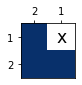

error_count:1


In [245]:
for row in range(board2x2.height):
    for col in range(board2x2.width):
        value = BoardMark.BLACK if probs2x2[row, col] > 0.5 else BoardMark.FILLER
        if game2x2.is_action_valid(row, col, value):
            board2x2.mark(row, col, value)
        else: 
            alt_value = BoardMark.FILLER if probs2x2[row, col] >= 0.5 else BoardMark.BLACK    
            board2x2.mark(row, col, alt_value)

game2x2.show_board()
print(f"error_count:{game2x2.errors}")

In [10]:
clues5x5s

{'rows': [1, 3, [1, 1], 3, 5], 'cols': [1, 4, [2, 2], 4, 1]}

In [12]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

In [15]:
sum_row_0 = sum(puzzle5x5s.norm_clues['rows'][0])
sum_row_0

1

In [16]:
sum_row_2 = sum(puzzle5x5s.norm_clues['rows'][2])
sum_row_2

2

In [248]:
probs5x5s = np.full((board5x5s.height, board5x5s.width), -1, dtype=float)
for i_row in range(len(clues5x5s['rows'])):
    sum_row = sum(puzzle5x5s.norm_clues['rows'][i_row])
    for i_col in range(len(clues5x5s['cols'])):
        sum_col = sum(puzzle5x5s.norm_clues['cols'][i_col])
        probs5x5s[i_row, i_col] = max((sum_row/board5x5s.width), (sum_col/board5x5s.height))
        
probs5x5s

array([[0.2, 0.8, 0.8, 0.8, 0.2],
       [0.6, 0.8, 0.8, 0.8, 0.6],
       [0.4, 0.8, 0.8, 0.8, 0.4],
       [0.6, 0.8, 0.8, 0.8, 0.6],
       [1. , 1. , 1. , 1. , 1. ]])

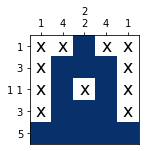

error_count:11


In [249]:
probs = probs5x5s_alt
for row in range(board5x5s.height):
    for col in range(board5x5s.width):
        value = BoardMark.BLACK if probs[row, col] > 0.5 else BoardMark.FILLER
        if game5x5s.is_action_valid(row, col, value):
            board5x5s.mark(row, col, value)
        else: 
            alt_value = BoardMark.FILLER if probs5x5s[row, col] >= 0.5 else BoardMark.BLACK    
            board5x5s.mark(row, col, alt_value)

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")

MC

In [21]:
import random

random.uniform(0,1)

0.3735395259734938

In [ ]:
p = 0.75
for i in range(10):
    value = BoardMark.BLACK if random.uniform(0,1)<=p else BoardMark.FILLER
    print(value)

[1, 1, 1, 1]


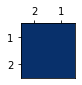

[1, 0, 1, 1]


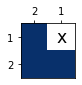

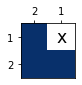

In [251]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

def mc_sampler():
    X = []
    for row in range(board2x2.height):
        for col in range(board2x2.width):
            is_black = np.random.normal(probs2x2[row, col], 0.1) >= 0.5 
            #is_black = random.uniform(probs2x2[row, col],1) >= 0.5 
            value = BoardMark.BLACK.value if is_black else BoardMark.FILLER.value
            X.append(value)
    return X

solved = False
sample = None
samples = []
while(not solved):
    sample =  mc_sampler()
    if not sample in samples:
        samples.append(sample)
        print(sample)
        board2x2.fill_all(sample)
        game2x2.show_board()
        solved = game2x2.is_expected_solution(sample)

board2x2.fill_all(sample)
game2x2.show_board()

In [93]:
np.random.normal(0.8,0.1)

0.6924447838722496

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]


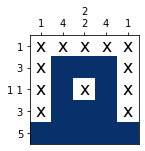

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]


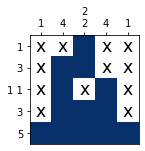

[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]


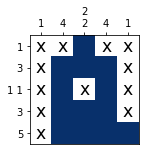

[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]


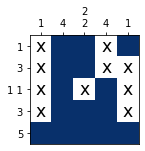

[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]


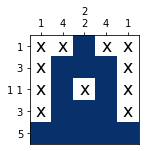

In [252]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board
probs = probs5x5s_alt

def mc_sampler():
    X = []
    for row in range(board5x5s.height):
        for col in range(board5x5s.width):
            is_black = np.random.normal(probs[row, col], 0.2) >= 0.5 
            value = BoardMark.BLACK.value if is_black else BoardMark.FILLER.value
            X.append(value)
    return X

solved = False
sample = None
samples = []
i = 0
while(not solved and i<50):
    sample =  mc_sampler()
    if not sample in samples:
        samples.append(sample)
        print(sample)
        board5x5s.fill_all(sample)
        game5x5s.show_board()
        solved = game5x5s.is_expected_solution(sample)
    i += 1



In [108]:
probs5x5s_alt = np.full((board5x5s.height, board5x5s.width), -1, dtype=float)
for i in range(len(solution5x5s.flat[:])):
        probs5x5s_alt.flat[i] =  0.75 if solution5x5s.flat[i] == 1 else 0.25
        
probs5x5s_alt

array([[0.25, 0.25, 0.75, 0.25, 0.25],
       [0.25, 0.75, 0.75, 0.75, 0.25],
       [0.25, 0.75, 0.25, 0.75, 0.25],
       [0.25, 0.75, 0.75, 0.75, 0.25],
       [0.75, 0.75, 0.75, 0.75, 0.75]])

# TODO compute probs

In [ ]:
## Wrap up

compute probs / update probs

# 7. Mathematic approach

simpy, sympy, cypy

# 8. Optimization by Genetic Algorithm

"genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection" - Wikipedia

TODO how could it work here, explain a little bit the selection process

https://pypi.org/project/geneticalgorithm/
    
geneticalgorithm is a Python library distributed on Pypi for implementing standard and elitist genetic-algorithm (GA). This package solves continuous, combinatorial and mixed optimization problems with continuous, discrete, and mixed variables. It provides an easy implementation of genetic-algorithm (GA) in Python.

We will use geneticalgorithm for this demonstration because it is more simple and fit this case. Plase not that there is also PyGAD

https://pygad.readthedocs.io/en/latest/

PyGAD is an open-source Python library for building the genetic algorithm and optimizing machine learning algorithms. It works with Keras and PyTorch.

PyGAD supports different types of crossover, mutation, and parent selection operators. PyGAD allows different types of problems to be optimized using the genetic algorithm by customizing the fitness function.

## 8.1. Example

In [ ]:
! pip install geneticalgorithm

Assume we want to find a set of X=(x1,x2,x3) that minimizes function f(X)=x1+x2+x3 where X can be any integer number in [0,10].

In [ ]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)

varbound=np.array([[0,10]]*3)

model=ga(function=f,dimension=3,variable_type='int',variable_boundaries=varbound)

model.run()


In a nonogram 2x2 we want to find a set of X=(x1,x2,x3,x4) that minimizes an error function f(X)=x1+x2+x3 where X can be any integer number in [0,1].
The error function compute the deviation from the clues.

## 8.2. Proof of concept on 2x2

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

to make it simple we will use the overall sum. The real function should compare col/row sums on X with clues

In [ ]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    # assume we know a solution to avoid ilplementing the sums
    # minimizing the error
    game2x2.is_expected_solution(X.tolist())
    return game2x2.errors

varbound=np.array([[0,1]]*puzzle2x2.cells_count)

model=ga(function=f, 
         dimension=puzzle2x2.cells_count, 
         variable_type='int',
         variable_boundaries=varbound)

model.run()

In [ ]:
# TODO collect samples

In [113]:
convergence=model.report
convergence

[8.0,
 6.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
solution = model.output_dict
solution

Please note that it found any array with three 1 and one 0. This is caused by the error function being too loose.
In the dict
- variable contains the optimized output
- function is the residual error after the model ran

In [ ]:
board2x2.fill_all(solution['variable'].tolist())
game2x2.show_board()

Test 5x5

In [87]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

 The best solution found:                                                                           
 [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]

 Objective function:
 0.0


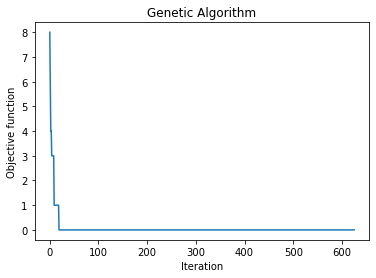

In [112]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    # assume we know a solution to avoid ilplementing the sums
    # minimizing the error
    game5x5s.is_expected_solution(X.tolist())
    return game5x5s.errors

varbound=np.array([[0,1]]*puzzle5x5s.cells_count)

model=ga(function=f, 
         dimension=puzzle5x5s.cells_count, 
         variable_type='int',
         variable_boundaries=varbound)

model.run()

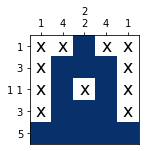

In [90]:
solution = model.output_dict
board5x5s.fill_all(solution['variable'].tolist())
game5x5s.show_board()

## 8.3. Wrap up

What works:
- it is simple to design and implement
- pretty easy to use
- it works on a numpy which will make it easy to compute rules

Limitation:
- May be overkill for this simple problem


This prrof of concept is 

Computations in the error function may use reshape and np.sum to cimpute sums on X. And then compare each sums to each clue in order to compute the abs error sum element by element. 

In [ ]:
states = np.array([1, 0, 1, 1]).reshape(2,2)
states

In [ ]:
states.sum(axis=0) # O col

In [ ]:
states.sum(axis=1) # 1 col

- Ideation: 10mn
- Design: 10mn - feature out that X is a numpty arry
- Implementation: 20mn  - error function (but only sum up, not real rules, estimated to 1h)

# 9. Machine Learning

TODO

# 10. Wrap up

This quick exploration of ways of solving this problem show that we need some additional components :
- a game engine which provides the try-and-error validation and the board validation 
- some operation thate were identified in episode 01: is the board completed, is the board valid
- a puzzle class with some operations to transform the clues and compute black count and cels count
- try-and-error and learning process will require something in between not done and done in order to improve on rewards:   number of cells completed/undefined, number of errors, number of valid celss


In [ ]:
TODO
multi plotter
error managemennt 
check episode 06 list